# 1. Install and Import Dependencies

In [114]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [115]:
# !pip install stable-baselines3[extra] protobuf==3.20.*

In [116]:
# !pip install mss pydirectinput pytesseract

In [117]:
# !pip install numpy matplotlib

In [118]:
# !pip install opencv-python

In [119]:
# !pip install gym

In [120]:
URL = "chrome://dino/"

In [121]:
from mss import mss        # To capture screen
import pydirectinput       # Sending commands
import cv2                 # For frame processing
import numpy as np         # Transformation
import pytesseract         # OCR for game over extraction

from matplotlib import pyplot as plt       # For plotting
import time                                # Bring time for pauses
from gym import Env                        # Environment components
from gym.spaces import Box, Discrete       # Environment components

# 2. Build the Environment

## 2.1 Create Environment

In [122]:
class WebGame(Env):
    
    # Setup the environment action and observation shapes
    def __init__(self):
        # Subclass model
        super().__init__()
        
        # Box for multi dimesional array. shape is 1 batch 83 high and 100 wide.
        # data type is numpy integer unit 8 since it is compressed data.
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        
        # 3 action to do Jumb, Down and No operation
        self.action_space = Discrete(3)
        
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}
    
    
    
    
    # what is called to do something in the game
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        
        if action != 2:
            pydirectinput.press(action_map[action])
        
        # Checking whether game is done
        done, done_cap = self.get_done()
        # get the next observation
        new_observation = self.get_observation()
        # Reward - we get to a point for every frame we are alive
        reward = 1
        # Info dictionary
        info = {}
        return new_observation, reward, done, info
        

    
    # Visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:, :, :3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

            
    
    # restart the game
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
        
    
    # Close down the observatrion
    def close(self):
        cv2.destroyAllWindows()
    
    
    
    # Get the part of the observation of the game that we want
    def  get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)   # To get screen capture of game
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)                                 # Set the Grayscale
        resized = cv2.resize(gray, (100,83))                                         # Resize
        channel = np.reshape(resized, (1,83,100))                                    # Add channels first
        return channel
    
    
    
    # Get the done text using OCR
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        
        # Apply OCR
        done = False
        pytesseract.pytesseract.tesseract_cmd =r'C:/Program Files/Tesseract-OCR/tesseract.exe'
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

# 2.2 Test Environment

In [123]:
env = WebGame()

In [124]:
obs=env.get_observation()

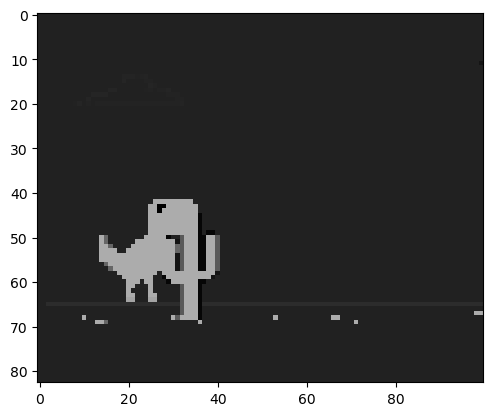

In [125]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR));

In [126]:
done, done_cap = env.get_done()

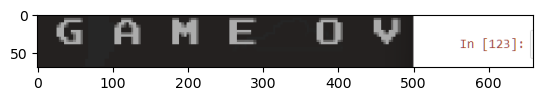

In [127]:
plt.imshow(done_cap);

In [128]:
pytesseract.image_to_string(done_cap)[:4]

'G& A'

In [129]:
done

False

In [130]:
for episode in range(2): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

Total Reward for episode 0 is 19
Total Reward for episode 1 is 12


# 3. Train the Model

## 3.1 Create Callback

In [131]:
# !pip install stable-baselines3[extra]

In [132]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [133]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [134]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [135]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [136]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [137]:
# buffer_size=1200000 for 32gb will be ok
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=2, buffer_size=3000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [139]:
# total_timesteps=100000 will give good model
model.learn(total_timesteps=3000, callback=callback)

Logging to ./logs/DQN_5
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.857    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 22       |
|    total_timesteps  | 45       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.2     |
|    ep_rew_mean      | 12.2     |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 48       |
|    total_timesteps  | 98       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.3     |
|    ep_rew_mean      | 13.3     |
|    exploration_rate | 0.493    |
| time/               |        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.2     |
|    ep_rew_mean      | 14.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 88       |
|    fps              | 2        |
|    time_elapsed     | 582      |
|    total_timesteps  | 1254     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00115  |
|    n_updates        | 63       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.3     |
|    ep_rew_mean      | 14.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 92       |
|    fps              | 2        |
|    time_elapsed     | 607      |
|    total_timesteps  | 1314     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000822 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 13.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 2        |
|    time_elapsed     | 1003     |
|    total_timesteps  | 2139     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.19e-05 |
|    n_updates        | 284      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.6     |
|    ep_rew_mean      | 13.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 156      |
|    fps              | 2        |
|    time_elapsed     | 1028     |
|    total_timesteps  | 2191     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.58e-05 |
|    n_updates      

In [143]:
model.save("train/best_model")

In [153]:
model = DQN.load('train/best_model.zip')

# 4. Test out Model   

In [154]:
for episode in range(15): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 13
Total Reward for episode 1 is 13
Total Reward for episode 2 is 10
Total Reward for episode 3 is 13
Total Reward for episode 4 is 10
Total Reward for episode 5 is 12
Total Reward for episode 6 is 10
Total Reward for episode 7 is 11
Total Reward for episode 8 is 20
Total Reward for episode 9 is 12
Total Reward for episode 10 is 13
Total Reward for episode 11 is 10
Total Reward for episode 12 is 11
Total Reward for episode 13 is 10
Total Reward for episode 14 is 12
